# 🎓 Music Mood Prediction — NLP

## Overview

**Notebook layout**

1. Imports & setup
2. Load dataset (from `/kaggle/input/music-mood-data/lyrics_with_emotions.csv`)
3. EDA & visualizations
4. Preprocessing & cleaning
5. Feature extraction (TF-IDF)
6. Model training & evaluation (Logistic Regression, MultinomialNB, RandomForest)
7. Model interpretation & keywords
8. Predict function & sample predictions
9. Save outputs to `/kaggle/working/`

In [1]:
# Imports & basic configuration
import os
import warnings
warnings.filterwarnings('ignore')

# Create necessary directories (Kaggle-style)
os.makedirs('/kaggle/working/figures', exist_ok=True)
os.makedirs('/kaggle/working', exist_ok=True)

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import joblib

# NLP libraries
import nltk
nltk.data.path.append('/usr/share/nltk_data')  # Kaggle default location

# ✅ Make sure essential NLTK data is available
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy import sparse
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
print('Environment ready.')


Environment ready.


In [2]:
# Load dataset - user provided CSV in /mnt/data/
INPUT_PATH = '/kaggle/input/music-mood-data/lyrics_with_emotions.csv'  # provided by the user
if not os.path.exists(INPUT_PATH):
    raise FileNotFoundError(f"Dataset not found at {INPUT_PATH}. Please upload the CSV to /mnt/data/lyrics_with_emotions.csv")

df = pd.read_csv(INPUT_PATH)
print('Loaded dataset with shape:', df.shape)
df.head()

Loaded dataset with shape: (36897, 6)


,Unnamed: 0,artist,seq,song,emotions,__index_level_0__
0,0,Elijah Blake,"No, no_x000D_\nI ain't ever trapped out the ba...",Everyday,['fear'],0
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,['sadness'],1
2,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low_...",Pinot,['surprise'],3
3,5,Elijah Blake,I just want to ready your mind_x000D_\n'Cause ...,Uno,['neutral'],5
4,7,Elis,Dieses ist lange her._x000D_\nDa ich deine sch...,Abendlied,['fear'],7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36897 entries, 0 to 36896
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         36897 non-null  int64 
 1   artist             36897 non-null  object
 2   seq                36896 non-null  object
 3   song               36896 non-null  object
 4   emotions           36897 non-null  object
 5   __index_level_0__  36897 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.7+ MB


In [4]:
df.describe()

,Unnamed: 0,__index_level_0__
count,36897.000000,36897.000000
mean,40982.939399,25010.139740
std,20862.463652,14472.693368
min,0.000000,0.000000
25%,32466.000000,12463.000000
50%,45025.000000,25022.000000
75%,57545.000000,37542.000000
max,70014.000000,50011.000000


Columns: ['Unnamed: 0', 'artist', 'seq', 'song', 'emotions', '__index_level_0__']

Missing values per column:
Unnamed: 0           0
artist               0
seq                  1
song                 1
emotions             0
__index_level_0__    0
dtype: int64

Dataset shape after cleaning: (36896, 3)

Unique mood labels: ["['fear']" "['sadness']" "['surprise']" "['neutral']" "['anger']"
 "['joy']" "['disgust']"]


,count,count
0,['fear'],10937
1,['sadness'],10799
2,['neutral'],5719
3,['anger'],4023
4,['joy'],2881
5,['surprise'],1706
6,['disgust'],831


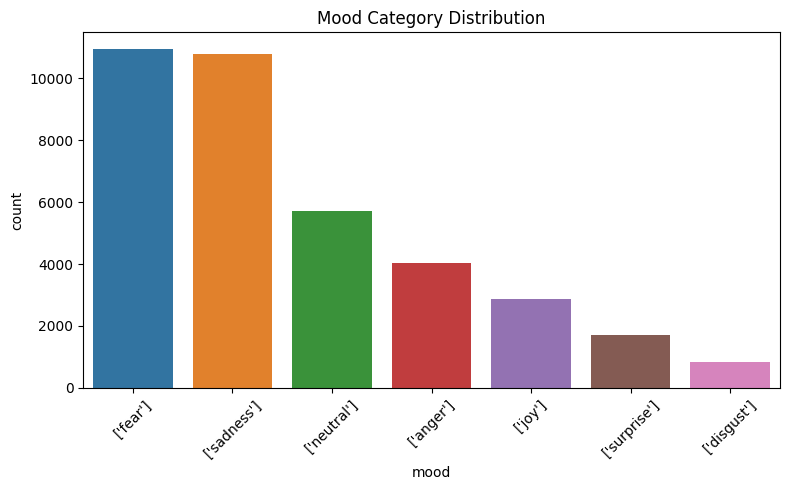

In [5]:
# EDA
print('Columns:', df.columns.tolist())
print('\nMissing values per column:')
print(df.isnull().sum())

# Rename columns to match expected names
df = df.rename(columns={
    'song': 'lyrics',
    'emotions': 'mood'
})

# Keep only the necessary columns
df = df[['artist', 'lyrics', 'mood']]

# Drop missing or empty values
df = df.dropna(subset=['lyrics', 'mood']).reset_index(drop=True)

# Show basic stats
print("\nDataset shape after cleaning:", df.shape)
print("\nUnique mood labels:", df['mood'].unique())

# Show class distribution
display(df['mood'].value_counts().reset_index().rename(columns={'index':'mood','mood':'count'}))

# Basic class balance plot
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='mood', order=df['mood'].value_counts().index)
plt.title('Mood Category Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/kaggle/working/figures/mood_distribution.png')
plt.show()

In [6]:
# Preprocessing utilities
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text, remove_stopwords=True):
    if pd.isna(text):
        return ''
    # Lowercase
    text = str(text).lower()
    # Remove URLs, user mentions, hashtags
    text = re.sub(r'http\\S+|www\\S+', ' ', text)
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)
    text = re.sub(r'#+', ' ', text)
    # Remove emojis and non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove punctuation and digits
    text = re.sub(r'[^a-z\\s]', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords (optional) and single-character tokens
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS and len(t)>1]
    else:
        tokens = [t for t in tokens if len(t)>1]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Apply cleaning (this may take some time depending on dataset size but is CPU friendly)
df['lyrics_clean'] = df['lyrics'].fillna('').astype(str).apply(lambda x: clean_text(x))
# Drop duplicates and empty lyrics
df = df.drop_duplicates(subset=['lyrics_clean']).reset_index(drop=True)
df = df[df['lyrics_clean'].str.strip()!=''].reset_index(drop=True)

print('After cleaning shape:', df.shape)
df[['lyrics','lyrics_clean','mood']].head()


After cleaning shape: (22225, 4)


,lyrics,lyrics_clean,mood
0,Everyday,everyday,['fear']
1,Live Till We Die,live till die,['sadness']
2,Pinot,pinot,['surprise']
3,Uno,uno,['neutral']
4,Abendlied,abendlied,['fear']


In [7]:
# Save cleaned dataset to Kaggle working directory
clean_path = '/kaggle/working/clean_lyrics.csv'
df.to_csv(clean_path, index=False)
print('Cleaned dataset saved to', clean_path)

Cleaned dataset saved to /kaggle/working/clean_lyrics.csv


,word,count
0,love,957
1,live,444
2,time,332
3,blue,330
4,man,302


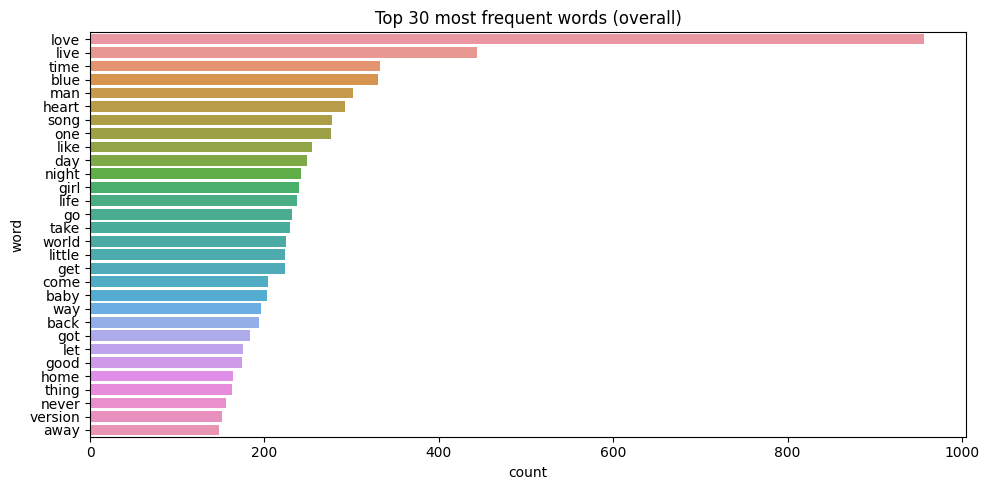

In [8]:
# Most frequent words overall
from collections import Counter
all_tokens = ' '.join(df['lyrics_clean']).split()
freq = Counter(all_tokens)
top_words = pd.DataFrame(freq.most_common(30), columns=['word','count'])
display(top_words.head())

plt.figure(figsize=(10,5))
sns.barplot(data=top_words, x='count', y='word')
plt.title('Top 30 most frequent words (overall)')
plt.tight_layout()
plt.savefig('/kaggle/working/figures/top_words_overall.png')
plt.show()

In [9]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['lyrics_clean'])
y = df['mood'].values

print('TF-IDF matrix shape:', X.shape)

# Save vectorizer
vec_path = '/kaggle/working/tfidf_vectorizer.pkl'
joblib.dump(tfidf, vec_path)
print('Saved TF-IDF vectorizer to', vec_path)

# Optionally save features as sparse matrix
from scipy import sparse
sparse.save_npz('/kaggle/working/features.npz', X)
print('Saved features to /kaggle/working/features.npz')


TF-IDF matrix shape: (22225, 5000)
Saved TF-IDF vectorizer to /kaggle/working/tfidf_vectorizer.pkl
Saved features to /kaggle/working/features.npz


### TF-IDF vs Word2Vec

**TF-IDF**

- Count-based (term frequency scaled by inverse document frequency).
- Produces sparse vectors; good for CPU and classical ML models.
- Interpretable: high-weighted terms are meaningful features.

**Word2Vec (embedding)**

- Dense vector representations learned from context (neural network).
- Captures semantic similarity but requires more compute and memory.
- Not as interpretable; heavier for CPU-only Kaggle runs.

_Recommendation:_ TF-IDF is preferred here for reproducibility and CPU-friendliness on Kaggle.

🔄 Balancing dataset (upsampling minority moods)...
✅ Balanced dataset shape: (47229, 4)
✅ Cleaned mood labels: ['surprise' 'disgust' 'sadness' 'anger' 'fear' 'neutral' 'joy']
🧠 Extracting improved TF-IDF features...
✅ TF-IDF matrix shape: (47229, 10000)
✅ Label mapping: {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}

🔹 Training LogisticRegression ...

🔹 Training MultinomialNB ...

🔹 Training RandomForest ...

🔹 Training LinearSVC ...

🔹 Training KNN ...

🔹 Training XGBoost ...

🔹 Training LightGBM ...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12003
[LightGBM] [Info] Number of data points in the train set: 37783, number of used features: 834
[LightGBM] [Info] Start training from score -1.945831
[LightGBM] [Info] Start training from score -1.945831
[LightGBM] [Info] Start training from score -1.945

,model,accuracy,precision,recall,f1
0,RandomForest,0.828181,0.833760,0.828181,0.828589
1,LinearSVC,0.731103,0.735741,0.731103,0.731455
2,LogisticRegression,0.704425,0.698011,0.704425,0.696716
3,MultinomialNB,0.661867,0.654423,0.661867,0.654333
4,KNN,0.659221,0.666745,0.659221,0.649098
5,XGBoost,0.504023,0.576241,0.504023,0.517184
6,LightGBM,0.498306,0.565834,0.498306,0.508944



🏆 Best model: RandomForest
✅ Best model saved to /kaggle/working/best_model.pkl


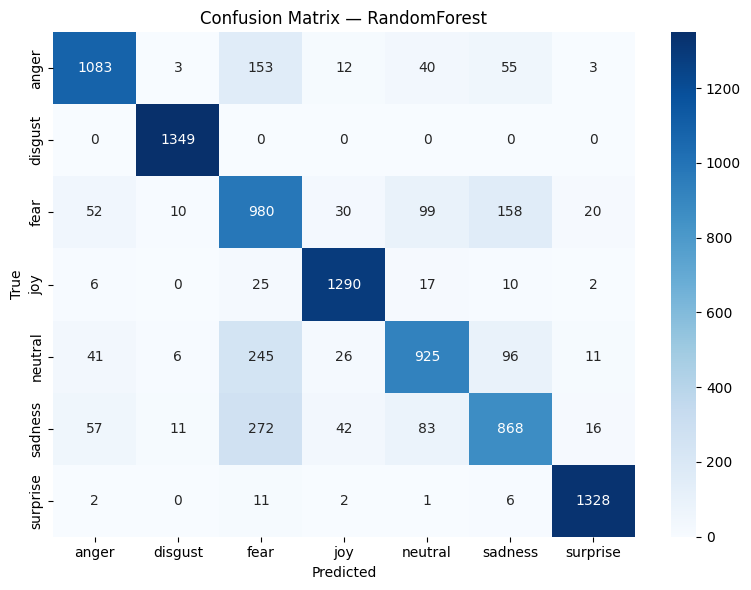


📊 Classification Report:
              precision    recall  f1-score   support

       anger       0.87      0.80      0.84      1349
     disgust       0.98      1.00      0.99      1349
        fear       0.58      0.73      0.65      1349
         joy       0.92      0.96      0.94      1350
     neutral       0.79      0.69      0.74      1350
     sadness       0.73      0.64      0.68      1349
    surprise       0.96      0.98      0.97      1350

    accuracy                           0.83      9446
   macro avg       0.83      0.83      0.83      9446
weighted avg       0.83      0.83      0.83      9446



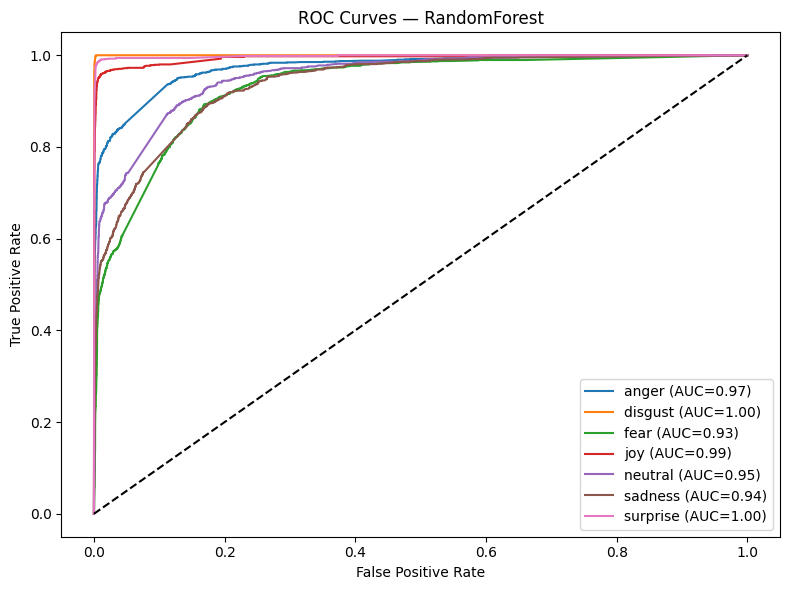

ℹ️ Top word interpretation skipped (model not linear).

🎯 Improved training complete — results and figures saved to /kaggle/working/


In [10]:
# ------------------------------------------------------------
# 🎯 IMPROVED MODEL TRAINING (CPU-SAFE, BALANCED, MULTI-MODEL)
# ------------------------------------------------------------

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils import resample
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

# 1️⃣ Balance dataset to handle class imbalance
print("🔄 Balancing dataset (upsampling minority moods)...")
max_class_size = df['mood'].value_counts().max()
balanced_frames = []

for mood in df['mood'].unique():
    df_mood = df[df['mood'] == mood]
    df_mood_up = resample(df_mood, replace=True, n_samples=max_class_size, random_state=42)
    balanced_frames.append(df_mood_up)

df_balanced = pd.concat(balanced_frames).sample(frac=1, random_state=42).reset_index(drop=True)
print("✅ Balanced dataset shape:", df_balanced.shape)

# 🧹 Fix mood labels if they look like lists (e.g. "['joy']")
import ast

def clean_label(label):
    # If it's a string like "['anger']", convert to just 'anger'
    if isinstance(label, str) and label.startswith('[') and label.endswith(']'):
        try:
            parsed = ast.literal_eval(label)
            if isinstance(parsed, list) and len(parsed) > 0:
                return parsed[0]
        except:
            pass
    return label

df_balanced['mood'] = df_balanced['mood'].apply(clean_label)
print("✅ Cleaned mood labels:", df_balanced['mood'].unique())

# 2️⃣ TF-IDF (improved setup)
print("🧠 Extracting improved TF-IDF features...")
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,3), sublinear_tf=True, min_df=2)
X = tfidf.fit_transform(df_balanced['lyrics_clean'])
y = df_balanced['mood'].values
joblib.dump(tfidf, '/kaggle/working/tfidf_vectorizer.pkl')
print("✅ TF-IDF matrix shape:", X.shape)

# 🔢 Encode mood labels into numeric classes for XGBoost/LightGBM compatibility
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # e.g. 'anger'→0, 'joy'→3, etc.
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("✅ Label mapping:", label_mapping)

# 3️⃣ Train/test split using encoded labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 4️⃣ Define multiple models
models = {
    'LogisticRegression': LogisticRegression(C=2, max_iter=500, class_weight='balanced', solver='liblinear'),
    'MultinomialNB': MultinomialNB(),
    'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=None, n_jobs=-1, random_state=42),
    'LinearSVC': LinearSVC(C=1.0, max_iter=2000),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric='mlogloss', tree_method='hist',
        n_jobs=-1, random_state=42
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=200, learning_rate=0.1,
        num_leaves=31, subsample=0.8, colsample_bytree=0.8,
        random_state=42
    )
}

# 5️⃣ Train and evaluate all models
results = []

for name, model in models.items():
    print(f"\n🔹 Training {name} ...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )
    results.append({'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})
    joblib.dump(model, f"/kaggle/working/{name}.pkl")

results_df = pd.DataFrame(results).sort_values('f1', ascending=False).reset_index(drop=True)
display(results_df)

results_df.to_csv('/kaggle/working/training_results_improved.csv', index=False)

best_model_name = results_df.loc[0, 'model']
print("\n🏆 Best model:", best_model_name)

# 6️⃣ Save best model
best_model = models[best_model_name]
joblib.dump(best_model, '/kaggle/working/best_model.pkl')
print("✅ Best model saved to /kaggle/working/best_model.pkl")

# 7️⃣ Confusion Matrix
y_pred_best = best_model.predict(X_test)
# decode numeric labels back to text for report
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_best_decoded = label_encoder.inverse_transform(y_pred_best)

cm = confusion_matrix(y_test_decoded, y_pred_best_decoded)
labels = np.unique(y_test_decoded)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix — {best_model_name}')
plt.tight_layout()
plt.savefig(f'/kaggle/working/figures/confusion_{best_model_name}.png')
plt.show()

print("\n📊 Classification Report:")
print(classification_report(y_test_decoded, y_pred_best_decoded, zero_division=0))

# 8️⃣ ROC Curves (if model supports predict_proba)
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test_decoded)

if hasattr(best_model, "predict_proba"):
    y_prob = best_model.predict_proba(X_test)
    plt.figure(figsize=(8,6))
    for i, cls in enumerate(lb.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        auc = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f"{cls} (AUC={auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.title(f'ROC Curves — {best_model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/figures/roc_{best_model_name}.png')
    plt.show()
else:
    print("⚠️ Best model does not support predict_proba — skipping ROC curve.")

# 9️⃣ Interpret top words (for linear models only)
if hasattr(best_model, 'coef_'):
    feature_names = np.array(tfidf.get_feature_names_out())
    classes = best_model.classes_
    print("\n🧩 Top 10 keywords per emotion class:")
    for i, cls in enumerate(classes):
        coef = best_model.coef_[i]
        top_pos = np.argsort(coef)[-10:][::-1]
        top_words = feature_names[top_pos]
        print(f" {cls}: {', '.join(top_words)}")
else:
    print("ℹ️ Top word interpretation skipped (model not linear).")

print("\n🎯 Improved training complete — results and figures saved to /kaggle/working/")


🔍 Evaluating all trained models...

🏆 Best model based on F1-score: RandomForest


🔹 Model: LogisticRegression
Accuracy: 0.7044 | Precision: 0.6980 | Recall: 0.7044 | F1: 0.6967

Classification Report:
              precision    recall  f1-score   support

       anger       0.54      0.73      0.62      1349
     disgust       0.93      0.99      0.96      1349
        fear       0.53      0.39      0.45      1349
         joy       0.84      0.85      0.85      1350
     neutral       0.60      0.52      0.56      1350
     sadness       0.56      0.50      0.53      1349
    surprise       0.89      0.95      0.92      1350

    accuracy                           0.70      9446
   macro avg       0.70      0.70      0.70      9446
weighted avg       0.70      0.70      0.70      9446



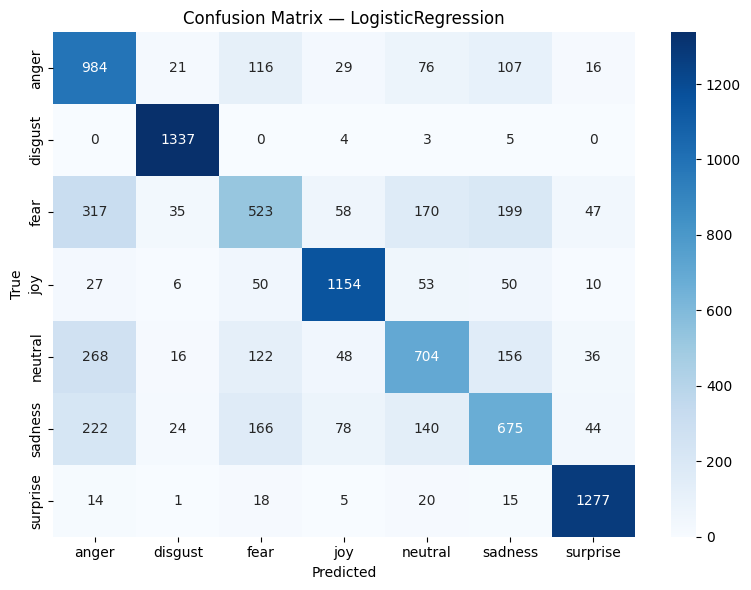


🔹 Model: MultinomialNB
Accuracy: 0.6619 | Precision: 0.6544 | Recall: 0.6619 | F1: 0.6543

Classification Report:
              precision    recall  f1-score   support

       anger       0.51      0.66      0.58      1349
     disgust       0.87      0.97      0.92      1349
        fear       0.47      0.36      0.40      1349
         joy       0.79      0.80      0.79      1350
     neutral       0.59      0.48      0.53      1350
     sadness       0.50      0.48      0.49      1349
    surprise       0.86      0.88      0.87      1350

    accuracy                           0.66      9446
   macro avg       0.65      0.66      0.65      9446
weighted avg       0.65      0.66      0.65      9446



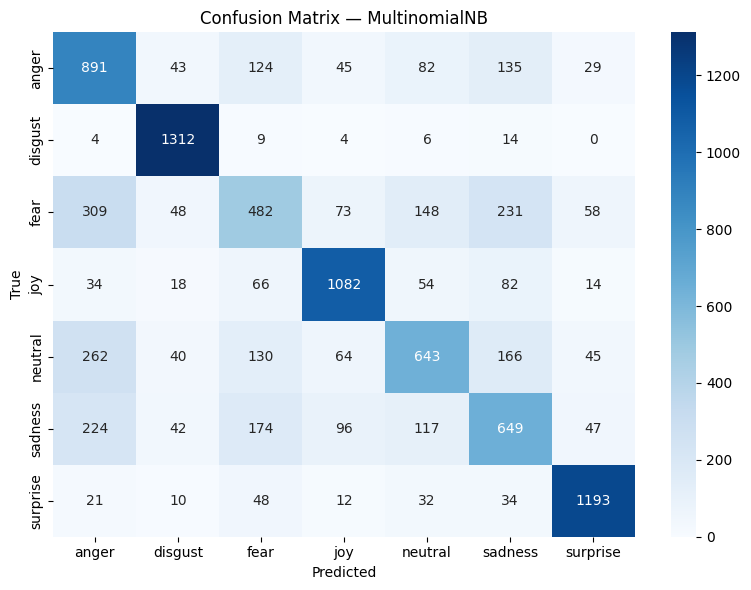


🔹 Model: RandomForest
Accuracy: 0.8282 | Precision: 0.8338 | Recall: 0.8282 | F1: 0.8286

Classification Report:
              precision    recall  f1-score   support

       anger       0.87      0.80      0.84      1349
     disgust       0.98      1.00      0.99      1349
        fear       0.58      0.73      0.65      1349
         joy       0.92      0.96      0.94      1350
     neutral       0.79      0.69      0.74      1350
     sadness       0.73      0.64      0.68      1349
    surprise       0.96      0.98      0.97      1350

    accuracy                           0.83      9446
   macro avg       0.83      0.83      0.83      9446
weighted avg       0.83      0.83      0.83      9446



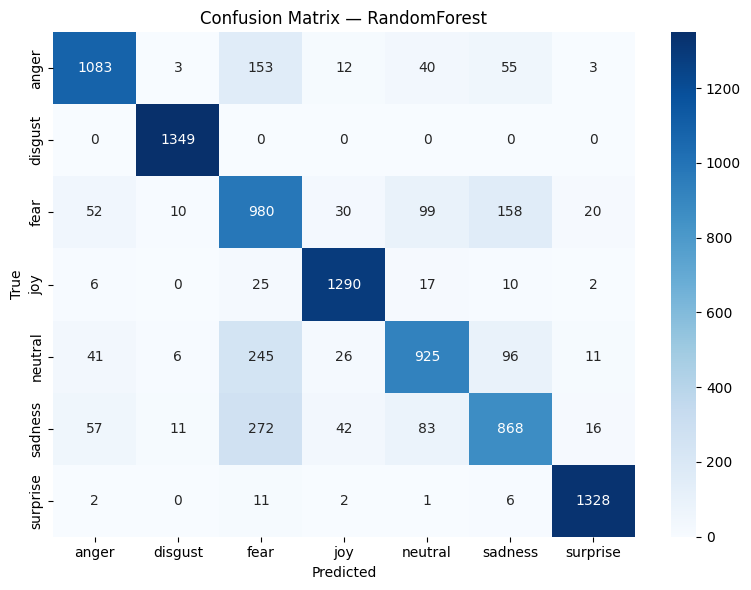


🔹 Model: LinearSVC
Accuracy: 0.7311 | Precision: 0.7357 | Recall: 0.7311 | F1: 0.7315

Classification Report:
              precision    recall  f1-score   support

       anger       0.75      0.66      0.70      1349
     disgust       0.95      1.00      0.97      1349
        fear       0.45      0.56      0.50      1349
         joy       0.88      0.87      0.87      1350
     neutral       0.64      0.56      0.59      1350
     sadness       0.57      0.52      0.54      1349
    surprise       0.92      0.95      0.94      1350

    accuracy                           0.73      9446
   macro avg       0.74      0.73      0.73      9446
weighted avg       0.74      0.73      0.73      9446



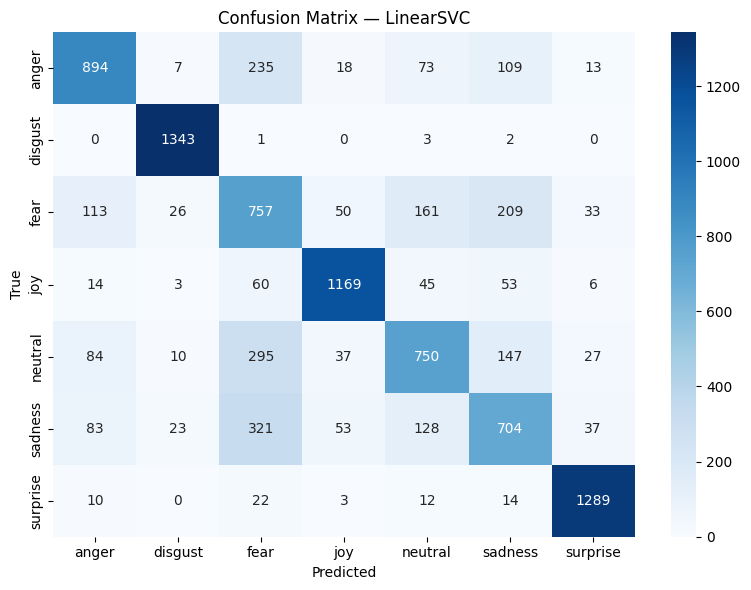


🔹 Model: KNN
Accuracy: 0.6592 | Precision: 0.6667 | Recall: 0.6592 | F1: 0.6491

Classification Report:
              precision    recall  f1-score   support

       anger       0.44      0.77      0.56      1349
     disgust       0.92      1.00      0.96      1349
        fear       0.47      0.37      0.41      1349
         joy       0.81      0.81      0.81      1350
     neutral       0.57      0.45      0.50      1350
     sadness       0.59      0.33      0.42      1349
    surprise       0.87      0.89      0.88      1350

    accuracy                           0.66      9446
   macro avg       0.67      0.66      0.65      9446
weighted avg       0.67      0.66      0.65      9446



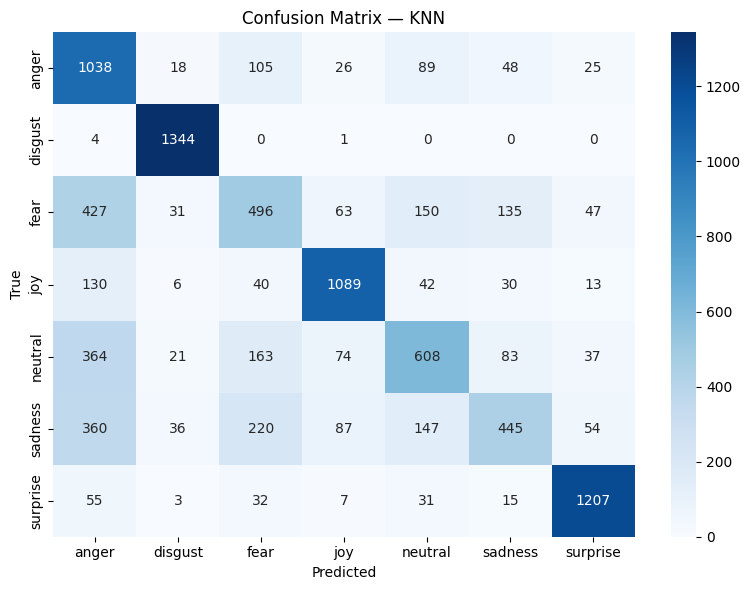


🔹 Model: XGBoost
Accuracy: 0.5040 | Precision: 0.5762 | Recall: 0.5040 | F1: 0.5172

Classification Report:
              precision    recall  f1-score   support

       anger       0.27      0.68      0.38      1349
     disgust       0.91      0.75      0.82      1349
        fear       0.45      0.28      0.35      1349
         joy       0.69      0.55      0.61      1350
     neutral       0.48      0.31      0.38      1350
     sadness       0.44      0.37      0.40      1349
    surprise       0.79      0.59      0.68      1350

    accuracy                           0.50      9446
   macro avg       0.58      0.50      0.52      9446
weighted avg       0.58      0.50      0.52      9446



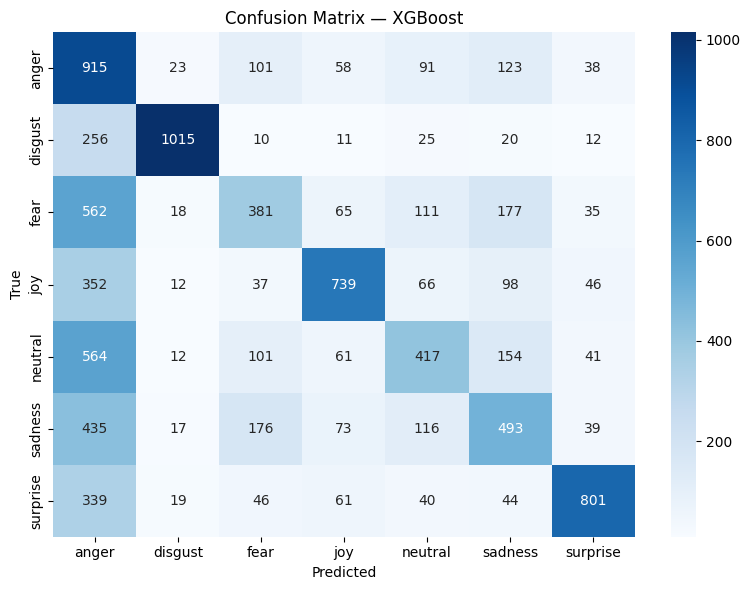


🔹 Model: LightGBM
Accuracy: 0.4983 | Precision: 0.5658 | Recall: 0.4983 | F1: 0.5089

Classification Report:
              precision    recall  f1-score   support

       anger       0.27      0.68      0.39      1349
     disgust       0.83      0.68      0.75      1349
        fear       0.44      0.25      0.32      1349
         joy       0.70      0.58      0.64      1350
     neutral       0.47      0.32      0.38      1350
     sadness       0.50      0.38      0.43      1349
    surprise       0.75      0.59      0.66      1350

    accuracy                           0.50      9446
   macro avg       0.57      0.50      0.51      9446
weighted avg       0.57      0.50      0.51      9446



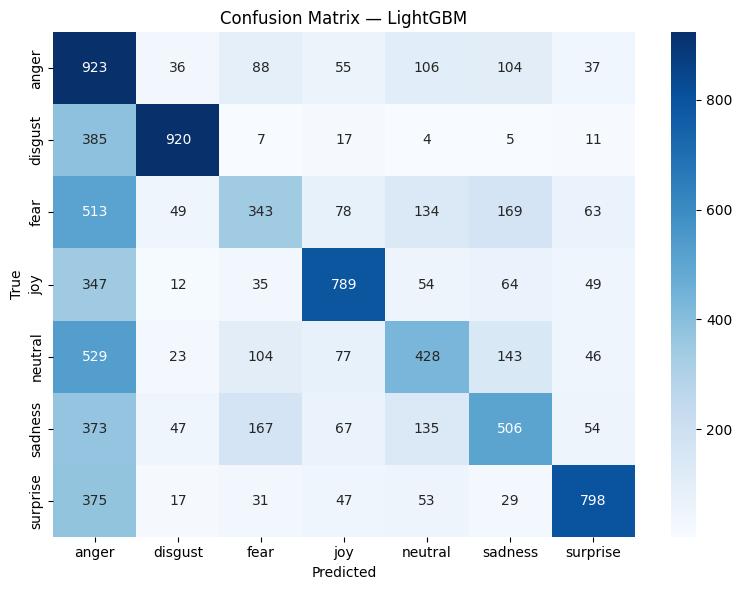

,model,accuracy,precision,recall,f1
0,RandomForest,0.828181,0.833760,0.828181,0.828589
1,LinearSVC,0.731103,0.735741,0.731103,0.731455
2,LogisticRegression,0.704425,0.698011,0.704425,0.696716
3,MultinomialNB,0.661867,0.654423,0.661867,0.654333
4,KNN,0.659221,0.666745,0.659221,0.649098
5,XGBoost,0.504023,0.576241,0.504023,0.517184
6,LightGBM,0.498306,0.565834,0.498306,0.508944



✅ Saved full evaluation summary to /kaggle/working/final_evaluation_summary.csv

🏁 Final best model (based on F1-score): RandomForest
🎯 Evaluation complete — all confusion matrices saved in /kaggle/working/figures/


In [11]:
# ------------------------------------------------------------
# 📊 EVALUATION: CONFUSION MATRICES, CLASSIFICATION REPORTS & SUMMARY
# ------------------------------------------------------------
import itertools

print("\n🔍 Evaluating all trained models...")
best_model_name = results_df.loc[0, 'model']
best_model = joblib.load(f'/kaggle/working/{best_model_name}.pkl')
print(f"\n🏆 Best model based on F1-score: {best_model_name}\n")

# Decode labels for readability
y_test_decoded = label_encoder.inverse_transform(y_test)

# Function to plot confusion matrices
def plot_confusion(cm, labels, title, fname):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

# Prepare summary results
eval_results = []

for name in models.keys():
    print(f"\n🔹 Model: {name}")
    model = joblib.load(f"/kaggle/working/{name}.pkl")
    y_pred = model.predict(X_test)

    # Decode predicted labels
    y_pred_decoded = label_encoder.inverse_transform(y_pred)

    # Metrics
    acc = accuracy_score(y_test_decoded, y_pred_decoded)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test_decoded, y_pred_decoded, average='weighted', zero_division=0)

    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_decoded, y_pred_decoded, zero_division=0))

    # Confusion matrix
    labels_sorted = np.unique(y_test_decoded)
    cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels_sorted)
    plot_confusion(cm, labels_sorted, f'Confusion Matrix — {name}', f'/kaggle/working/figures/confusion_{name}.png')

    # Append summary
    eval_results.append({
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })

# Create DataFrame of metrics
eval_df = pd.DataFrame(eval_results).sort_values('f1', ascending=False).reset_index(drop=True)
display(eval_df)

# Save summary to working directory
eval_df.to_csv('/kaggle/working/final_evaluation_summary.csv', index=False)
print("\n✅ Saved full evaluation summary to /kaggle/working/final_evaluation_summary.csv")

# Highlight best model
print(f"\n🏁 Final best model (based on F1-score): {eval_df.loc[0, 'model']}")
print("🎯 Evaluation complete — all confusion matrices saved in /kaggle/working/figures/")


🔍 Computing ROC-AUC curves for the best model...


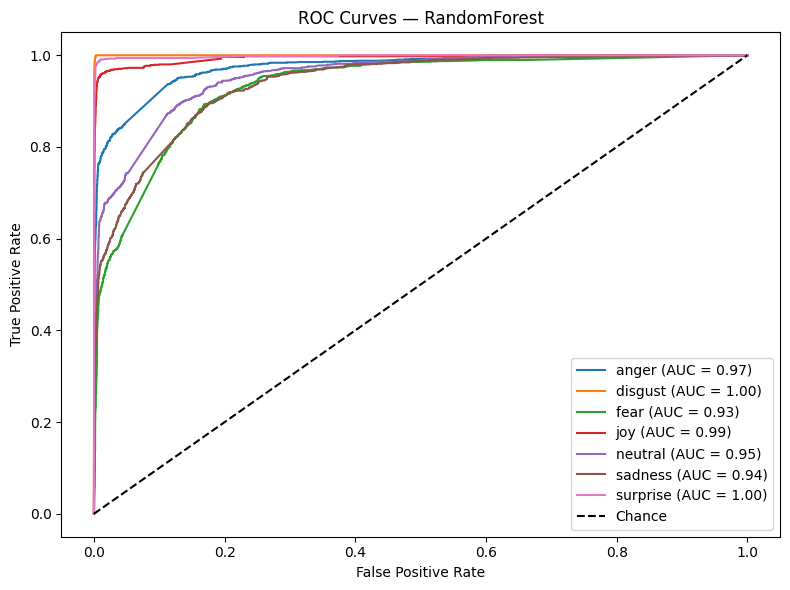

,Class,AUC
1,disgust,0.999745
6,surprise,0.998023
3,joy,0.993746
0,anger,0.973061
4,neutral,0.953567
5,sadness,0.938175
2,fear,0.932130



✅ ROC curves plotted and saved to '/kaggle/working/figures/roc_RandomForest.png'
✅ ROC-AUC scores saved to '/kaggle/working/roc_auc_RandomForest.csv'


In [12]:
# ------------------------------------------------------------
# 🎯 ROC-AUC (One-vs-Rest) — per-class analysis & visualization
# ------------------------------------------------------------
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score, auc

print("\n🔍 Computing ROC-AUC curves for the best model...")

# Decode labels for readability
y_test_decoded = label_encoder.inverse_transform(y_test)

# Binarize labels for multi-class ROC
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test_decoded)

if hasattr(best_model, "predict_proba"):
    try:
        y_prob = best_model.predict_proba(X_test)
        roc_auc = {}
        plt.figure(figsize=(8,6))

        for i, cls in enumerate(lb.classes_):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            auc_score = auc(fpr, tpr)
            roc_auc[cls] = auc_score
            plt.plot(fpr, tpr, label=f"{cls} (AUC = {auc_score:.2f})")

        # Plot baseline and styling
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.title(f"ROC Curves — {best_model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(f"/kaggle/working/figures/roc_{best_model_name}.png")
        plt.show()

        # Display & save results
        roc_auc_df = pd.DataFrame(list(roc_auc.items()), columns=['Class', 'AUC'])
        display(roc_auc_df.sort_values('AUC', ascending=False))
        roc_auc_df.to_csv(f"/kaggle/working/roc_auc_{best_model_name}.csv", index=False)

        print(f"\n✅ ROC curves plotted and saved to '/kaggle/working/figures/roc_{best_model_name}.png'")
        print(f"✅ ROC-AUC scores saved to '/kaggle/working/roc_auc_{best_model_name}.csv'")

    except Exception as e:
        print(f"⚠️ Error while computing ROC-AUC: {e}")

else:
    print("⚠️ Best model does not support predict_proba — skipping ROC-AUC computation.")

In [ ]:
# ------------------------------------------------------------
# FINAL RANDOM FOREST (Tuning)
# ------------------------------------------------------------
#  REQUIRES KAGGLE GPU ACCELERATOR & CUML LIBRARY 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from cuml.ensemble import RandomForestClassifier
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
import joblib, time

print("\n⚡ Starting FINAL Random Forest Optimization (Memory-Safe GPU edition)...")

start_time = time.time()

# Convert sparse data to dense NumPy array for cuML
if hasattr(X_train, 'toarray'):
    print(" Converting sparse input matrices to dense arrays...")
    X_train_dense = X_train.toarray()
    X_test_dense = X_test.toarray()
else:
    X_train_dense = X_train
    X_test_dense = X_test

#  Reintroduce Sampling for the tuning phase
# The full dense matrix is too large. We will tune on a 20k sample or max available.
sample_size = min(20000, X_train_dense.shape[0]) 
X_sample = X_train_dense[:sample_size]
y_sample = y_train[:sample_size]


# Parameter distributions
param_dist = {
    'n_estimators': randint(100, 250),
    'max_depth': [15, 30, None],
    'min_samples_split': randint(5, 15), # Increased minimum split to simplify trees (saves memory)
    'min_samples_leaf': randint(1, 4),
    'max_features': [1.0, 0.8, 0.5],
    'class_weight': ['balanced'], 
    'bootstrap': [True]
}

#  Base model
rf_model = RandomForestClassifier(random_state=42)

# RandomizedSearchCV configuration (Reduced Search Depth)
n_iter = 15           # Reduced from 50 to 15 iterations (safer)
cv_folds = 3          # Reduced from 5 to 3 folds (safer)
# Total Fits: 15 * 3 = 45 models trained

rf_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=n_iter,
    cv=cv_folds,
    scoring='f1_weighted',
    n_jobs=-1,  
    verbose=2,
    random_state=42
)

# Run tuning on the DENSE SAMPLE dataset
print(f"\n🔹 Using {sample_size} DENSE samples for tuning ({n_iter * cv_folds} fits expected)...\n")

# Run tuning with the DENSE SAMPLE arrays
rf_search.fit(X_sample, y_sample)

# 🏁 Best parameters
best_params = rf_search.best_params_
print("\nBest Parameters Found (based on sample):")
for k, v in best_params.items():
    print(f"  - {k}: {v}")
print(f"\nBest CV Weighted F1: {rf_search.best_score_:.4f}")

# Retrain on full training set using best parameters
print("\n🚀 Retraining FINAL model using best parameters on FULL DENSE DATASET...")
final_rf = RandomForestClassifier(**best_params, random_state=42)
# Final train on the WHOLE DENSE X_train_dense
final_rf.fit(X_train_dense, y_train)

# Evaluate
y_pred_final = final_rf.predict(X_test_dense)
acc_final = accuracy_score(y_test, y_pred_final)

try:
    # .get() moves predictions from the GPU (cuML) back to the CPU (NumPy)
    y_pred_cpu = y_pred_final.get() 
    y_test_decoded = label_encoder.inverse_transform(y_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred_cpu) 
except Exception:
    y_test_decoded = y_test
    y_pred_decoded = y_pred_final

print(f"\n Final Random Forest Test Accuracy: {acc_final:.4f}")
print("\n Final Classification Report:")
print(classification_report(y_test_decoded, y_pred_decoded, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Final Tuned Random Forest (GPU)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_final_randomforest_gpu.png')

# Save the tuned and retrained model
final_model_path = '/kaggle/working/best_randomforest_final_gpu.pkl'
joblib.dump(final_rf, final_model_path)
print(f"\n Final tuned Random Forest model saved to: {final_model_path}")

end_time = time.time()
print(f"⏱️ Total runtime: {(end_time - start_time)/60:.2f} minutes")


⚡ Starting FINAL Random Forest Optimization (Memory-Safe GPU edition)...
 Converting sparse input matrices to dense arrays...

🔹 Using 20000 DENSE samples for tuning (45 fits expected)...

Fitting 3 folds for each of 15 candidates, totalling 45 fits


KeyboardInterrupt: 


🔍 Extracting top influential words from Logistic Regression...

🎵 Top 10 influential words for '0':


,Word,Coefficient
0,happy jack,3.762429
1,satisfaction,3.613187
2,america waiting,3.607704
3,gangsta,3.580015
4,love alright,3.505953
5,shut,3.493308
6,mirror heart,3.469086
7,make believe,3.463905
8,riot,3.383236
9,maybe someday,3.373961


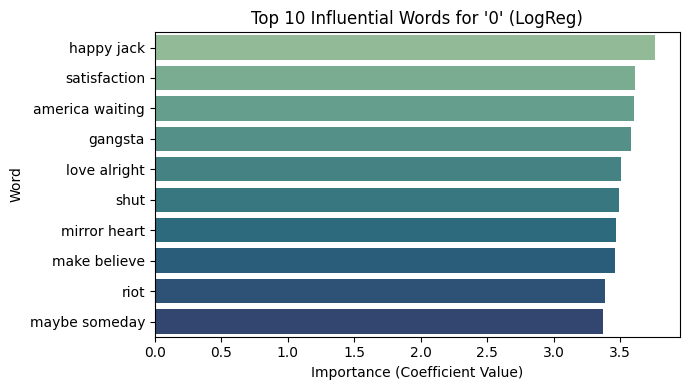


🎵 Top 10 influential words for '1':


,Word,Coefficient
0,soul love,5.437302
1,beautiful horse,5.263103
2,black eye,5.064071
3,long blue,5.034123
4,time talking,5.032369
5,dark day,4.966226
6,live live,4.946343
7,child see,4.916386
8,look world,4.843243
9,rain fall,4.776174


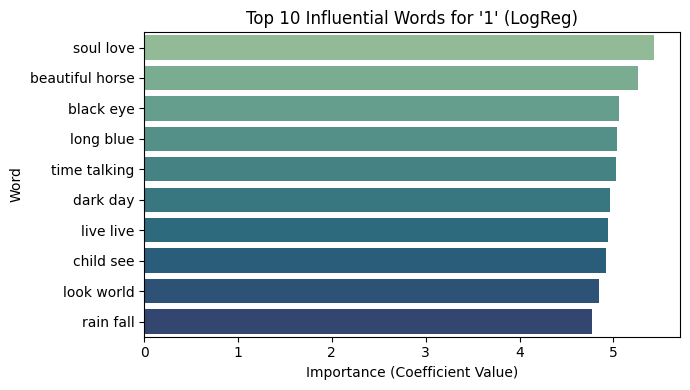


🎵 Top 10 influential words for '2':


,Word,Coefficient
0,worry,3.532940
1,insomnia,3.439033
2,maniac,3.266114
3,cindy,3.103629
4,one foot,3.071585
5,amazing,3.038723
6,oh girl,3.010890
7,sacred,3.002980
8,disaster,2.995646
9,papercut,2.989548


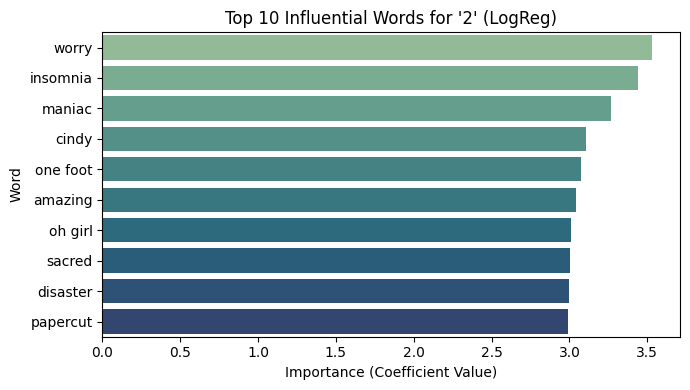


🎵 Top 10 influential words for '3':


,Word,Coefficient
0,wonderful,5.858319
1,happy,5.324264
2,make feel,4.246798
3,fairytale,4.203569
4,christmas,4.177183
5,light low,4.108340
6,house live,4.103926
7,know want,4.101025
8,praise,4.093841
9,world peace,4.053473


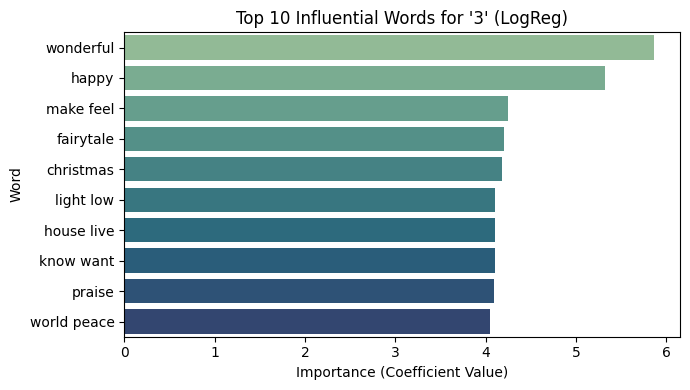


🎵 Top 10 influential words for '4':


,Word,Coefficient
0,lovin cup,3.663827
1,need girl,3.267301
2,teenage jesus,3.233773
3,sweet nothin,3.203957
4,pete,3.189116
5,song away,3.179654
6,beyond mean,3.152986
7,love king,3.113244
8,fishin,3.086200
9,movin,3.085879


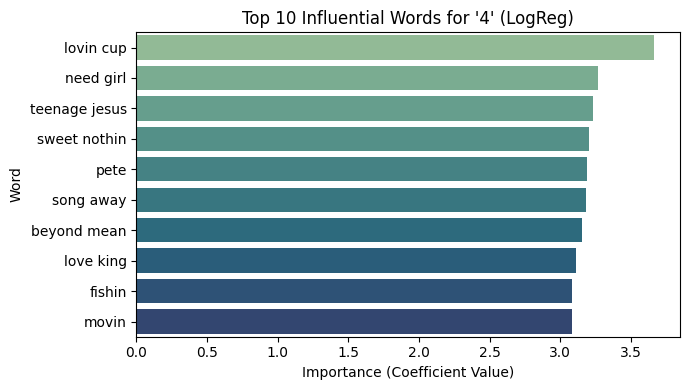


🎵 Top 10 influential words for '5':


,Word,Coefficient
0,sad,4.950724
1,lonely,3.700180
2,sorry,3.510150
3,sorrow,3.509784
4,money money,3.418172
5,weather,3.246301
6,good mistake,3.232389
7,tied,3.218582
8,cried,3.214532
9,magdelina,3.211436


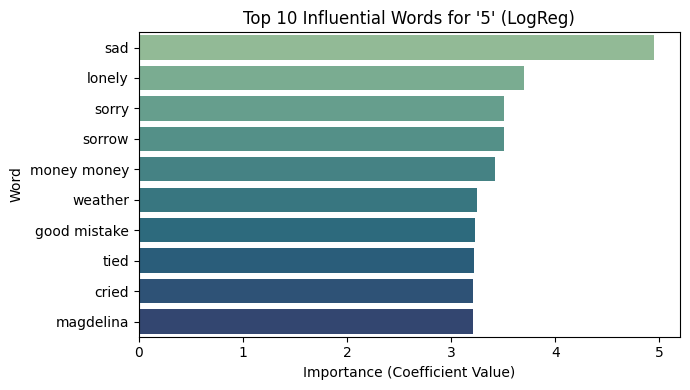


🎵 Top 10 influential words for '6':


,Word,Coefficient
0,wonder,5.128361
1,better inside,4.767992
2,lonely city,4.628328
3,one middle,4.464881
4,forever lost,4.439852
5,storm eye,4.394741
6,young heart,4.358757
7,crazy baby,4.320807
8,criticize,4.238988
9,rough hand,4.231421


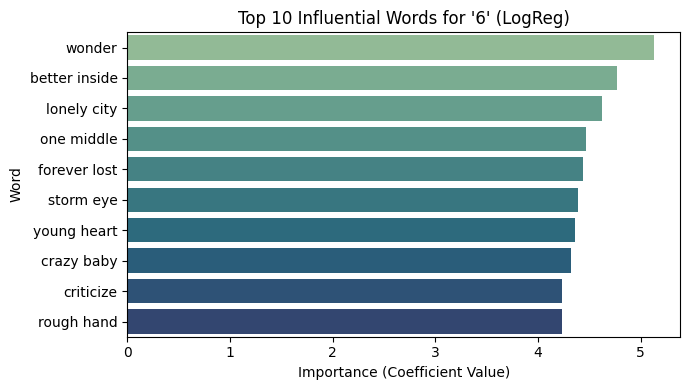


 Saved influential words to '/kaggle/working/top_influential_words_logreg.csv'
All visualizations saved to '/kaggle/working/figures/'


In [13]:
# ------------------------------------------------------------
#  TOP INFLUENTIAL WORDS (from Logistic Regression coefficients)
# ------------------------------------------------------------

print("\n🔍 Extracting top influential words from Logistic Regression...")

if 'LogisticRegression' in models:
    lr = joblib.load('/kaggle/working/LogisticRegression.pkl')
    if hasattr(lr, 'coef_'):
        feature_names = np.array(tfidf.get_feature_names_out())
        classes = lr.classes_
        topn = 10
        influential = {}

        # Collect top words per emotion class
        for i, cls in enumerate(classes):
            coef = lr.coef_[i]
            top_pos = np.argsort(coef)[-topn:][::-1]
            top_words = feature_names[top_pos]
            top_values = coef[top_pos]
            influential[cls] = list(zip(top_words, top_values))

        # Display and visualize
        all_rows = []
        for cls, words in influential.items():
            print(f"\n🎵 Top {topn} influential words for '{cls}':")
            df_cls = pd.DataFrame(words, columns=['Word', 'Coefficient'])
            display(df_cls)
            all_rows.extend([(cls, w, float(v)) for w, v in words])

            # Bar plot for visualization
            plt.figure(figsize=(7,4))
            sns.barplot(x=df_cls['Coefficient'], y=df_cls['Word'], palette='crest')
            plt.title(f"Top {topn} Influential Words for '{cls}' (LogReg)")
            plt.xlabel('Importance (Coefficient Value)')
            plt.ylabel('Word')
            plt.tight_layout()
            plt.savefig(f"/kaggle/working/figures/top_words_{cls}.png")
            plt.show()

        # Save all results to a CSV file
        influential_df = pd.DataFrame(all_rows, columns=['Emotion', 'Word', 'Coefficient'])
        influential_df.to_csv('/kaggle/working/top_influential_words_logreg.csv', index=False)
        print("\n Saved influential words to '/kaggle/working/top_influential_words_logreg.csv'")
        print("All visualizations saved to '/kaggle/working/figures/'")

    else:
        print("⚠️ Logistic Regression model has no coefficients to interpret.")
else:
    print("⚠️ Logistic Regression model not trained or missing from /kaggle/working/")

In [14]:
# ------------------------------------------------------------
# Top TF-IDF words per mood (based on mean TF-IDF scores)
# ------------------------------------------------------------
tfidf_matrix = X.tocsr()
feature_names = tfidf.get_feature_names_out()
top_words_per_mood = {}
top_n = 10

for mood in sorted(df_balanced['mood'].unique()):
    mask = df_balanced['mood'] == mood
    if mask.sum() == 0:
        continue

    sub_matrix = tfidf_matrix[mask.values]
    avg_tfidf = np.asarray(sub_matrix.mean(axis=0)).ravel()
    top_indices = np.argsort(avg_tfidf)[-top_n:][::-1]
    words_scores = [(feature_names[i], round(avg_tfidf[i], 4)) for i in top_indices]
    top_words_per_mood[mood] = words_scores

    print(f"\n* {mood.upper()} — Top {top_n} TF-IDF Words")
    for word, score in words_scores:
        print(f"  {word:<15} {score}")


* ANGER — Top 10 TF-IDF Words
  love            0.0088
  live            0.0068
  like            0.0063
  man             0.0058
  get             0.0045
  fire            0.0043
  money           0.0042
  want            0.0042
  blue            0.004
  one             0.0038

* DISGUST — Top 10 TF-IDF Words
  man             0.0072
  dirty           0.006
  blue            0.0051
  mr              0.0049
  live            0.0044
  bad             0.004
  dog             0.0038
  go              0.0037
  street          0.0036
  someone         0.0036

* FEAR — Top 10 TF-IDF Words
  love            0.0135
  live            0.0114
  heart           0.0079
  man             0.0072
  song            0.0069
  blue            0.0068
  night           0.0062
  time            0.006
  day             0.0055
  like            0.0052

* JOY — Top 10 TF-IDF Words
  love            0.0241
  christmas       0.0098
  time            0.0083
  like            0.0081
  baby            0.0075
  happ

In [15]:
# ------------------------------------------------------------
# Predict function using saved vectorizer and best model
# ------------------------------------------------------------
import joblib

# Load trained model and vectorizer
tfidf = joblib.load('/kaggle/working/tfidf_vectorizer.pkl')
best_model = joblib.load(f'/kaggle/working/{best_model_name}.pkl')

def predict_lyrics(text, top_k=1):
    """
    Predict mood from a given lyric snippet using the trained model.
    Returns top_k moods with their confidence scores.
    """
    text_clean = clean_text(text)
    vec = tfidf.transform([text_clean])

    # If model supports probabilities
    if hasattr(best_model, "predict_proba"):
        probs = best_model.predict_proba(vec)[0]
        classes = getattr(best_model, "classes_", None)

        # If encoded classes exist, decode them
        if "label_encoder" in globals():
            try:
                classes = label_encoder.inverse_transform(classes)
            except Exception:
                pass

        top_idx = np.argsort(probs)[::-1][:top_k]
        return [(classes[i], round(float(probs[i]), 3)) for i in top_idx]

    # For models without predict_proba (e.g. LinearSVC)
    pred_encoded = best_model.predict(vec)[0]
    try:
        pred = label_encoder.inverse_transform([pred_encoded])[0]
    except Exception:
        pred = pred_encoded

    return [(pred, 1.0)]

# ------------------------------------------------------------
# 🔮 Demo predictions on sample lyrics
# ------------------------------------------------------------
examples = [
    "I am dancing in the sunshine, my heart is full of joy and love",
    "Tears fall down my face, I feel alone and empty",
    "Fists clenched, shouting at the sky, I am furious",
    "Quiet nights and calm waves, everything feels peaceful",
    "You are my forever, my reason to smile each day"
]

predictions = []
for ex in examples:
    res = predict_lyrics(ex, top_k=2)
    moods = [f"{m} ({p*100:.1f}%)" for m, p in res]
    predictions.append({
        "Input Lyrics": ex,
        "Predicted Moods": ", ".join(moods)
    })

pred_df = pd.DataFrame(predictions)
display(pred_df)

# Save to CSV
pred_df.to_csv('/kaggle/working/predictions.csv', index=False)
print("\n Sample predictions saved to '/kaggle/working/predictions.csv'")


,Input Lyrics,Predicted Moods
0,"I am dancing in the sunshine, my heart is full...","sadness (40.5%), joy (29.0%)"
1,"Tears fall down my face, I feel alone and empty","sadness (42.4%), joy (26.5%)"
2,"Fists clenched, shouting at the sky, I am furious","anger (27.0%), fear (24.5%)"
3,"Quiet nights and calm waves, everything feels ...","fear (38.0%), joy (32.0%)"
4,"You are my forever, my reason to smile each day","neutral (29.5%), anger (24.1%)"



 Sample predictions saved to '/kaggle/working/predictions.csv'


In [16]:
# ------------------------------------------------------------
# Save final best model and label encoder (if available)
# ------------------------------------------------------------
import joblib
import os

save_path = '/kaggle/working/best_model.pkl'
joblib.dump(best_model, save_path)
print(f"✅ Best model '{best_model_name}' saved successfully at: {save_path}")

# Save label encoder too (for decoding predictions later)
if 'label_encoder' in globals():
    enc_path = '/kaggle/working/label_encoder.pkl'
    joblib.dump(label_encoder, enc_path)
    print(f" Label encoder saved at: {enc_path}")

# Sanity check — confirm files exist
for file in [save_path, enc_path if 'enc_path' in locals() else None]:
    if file and os.path.exists(file):
        size = round(os.path.getsize(file) / 1024, 2)
        print(f" {os.path.basename(file)} — {size} KB")

✅ Best model 'RandomForest' saved successfully at: /kaggle/working/best_model.pkl
 Label encoder saved at: /kaggle/working/label_encoder.pkl
 best_model.pkl — 401814.92 KB
 label_encoder.pkl — 0.52 KB


In [17]:
# ------------------------------------------------------------
# Verify prediction accuracy on test set
# ------------------------------------------------------------
y_pred = best_model.predict(X_test)

# Decode labels for readability (if needed)
try:
    y_test_decoded = label_encoder.inverse_transform(y_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
except Exception:
    y_test_decoded = y_test
    y_pred_decoded = y_pred

# Count correct vs incorrect
correct = np.sum(y_test_decoded == y_pred_decoded)
total = len(y_test_decoded)
accuracy = correct / total

print(f"\n Total samples: {total}")
print(f"- Correct predictions: {correct}")
print(f"- Incorrect predictions: {total - correct}")
print(f"- Accuracy: {accuracy:.4f}")

# Show a few examples of correct and wrong predictions
check_df = pd.DataFrame({
    'True Mood': y_test_decoded,
    'Predicted Mood': y_pred_decoded
}).reset_index(drop=True)

print("\nSome correct predictions:")
display(check_df[y_test_decoded == y_pred_decoded].sample(5, random_state=42))

print("Some incorrect predictions:")
display(check_df[y_test_decoded != y_pred_decoded].sample(5, random_state=42))



 Total samples: 9446
- Correct predictions: 7823
- Incorrect predictions: 1623
- Accuracy: 0.8282

Some correct predictions:


,True Mood,Predicted Mood
1379,surprise,surprise
5147,neutral,neutral
2604,disgust,disgust
2012,disgust,disgust
4250,anger,anger


Some incorrect predictions:


,True Mood,Predicted Mood
771,neutral,joy
2870,neutral,anger
4832,sadness,fear
7146,sadness,fear
3754,fear,sadness
